# Решение тестового задания на Data Science стажировку от Контур.
**Воронов Роман**, студент 2 курса Data Science трека университета Иннополис. Родной город: Екатеринбург

# Содержание
- Поверхностный анализ набора данных и извлекаемых фрагментов

- Работа с меткой "обеспечение гарантийных обязательств"
- - [Подробный анализ фрагментов для метки "обеспечение гарантийных обязательств"](#scrollTo=6Yr44XjW7Ivk)

- - - [Подготовка spacy](#scrollTo=KwxhBOdE_RAE)

- - [Создание модели на поиск фрагментов для "обеспечение гарантийных обязательств"](#scrollTo=t89mNHxyYm9B)

- Работа с меткой "обеспечение исполнения контракта"

- - [Подробный анализ фрагментов для метки "обеспечение исполнения контракта"](#scrollTo=23f6e707JGab)

- - [Создание модели на поиск фрагментов для "обеспечение исполнения контракта"](#scrollTo=zMoFwlJCQLXE)

- [Предсказание фрагментов, сохранение датафреймов](#scrollTo=f5R6ZzTO8oH-)

- [Дообучение одного из компонентов spacy на распознавание фрагментов по двум данным меткам](#scrollTo=bbOjUvEABRRX)

# 1. Поверхностный анализ набора данных и извлекаемых фрагментов
В этой части будет анализ не требующий глубоких знаний, продвинутых библиотек. Установка и импорт библиотек, небольшой препроцессинг данных и легкий анализ фрагментов: количество слов, длина предложений и так далее


In [ ]:
from google.colab import drive, output
import pandas as pd
import numpy as np
import random
import tqdm as tqdm
!pip install visualise_spacy_tree
import visualise_spacy_tree
from IPython.display import Image, display
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
!pip install pymorphy2
import pymorphy2
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
!pip install spacy==3.5.0
import spacy
from spacy import displacy
from spacy.tokens import DocBin
from spacy.util import minibatch, compounding
from spacy.training.example import Example
from spacy.training import offsets_to_biluo_tags
from spacy.language import Language

drive.mount("/content/drive")
output.clear()

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!python -m spacy download ru_core_news_lg # Установка модели spacy для русского языка
output.clear()

In [ ]:
nlp = spacy.load("ru_core_news_lg", disable = ["ner"])
#nlp = spacy.load("ru_core_news_lg")

In [ ]:
analyzer = pymorphy2.MorphAnalyzer() # Лемматизация

In [ ]:
train_df = pd.read_json("/content/drive/MyDrive/nlp_test_task_2023/dataset/train.json")
test_df = pd.read_json("/content/drive/MyDrive/nlp_test_task_2023/dataset/test.json")
train_df.head(2)

,id,text,label,extracted_part
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...


In [ ]:
test_df.head(1)

,id,text,label
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта


Проверим тренировочный набор на пустые значения перед работой с датафреймом

In [ ]:
train_df.isna().sum(axis=0) # Проверка на пустые значения

id                0
text              0
label             0
extracted_part    0
dtype: int64

Преобразую столбец extracted_part в тренировочном сете для удобства преобразовать в три новых столбца: извлеченная часть и индексы начала и конца.

In [ ]:
train_df.extracted_part[0]

{'text': ['Размер обеспечения исполнения контракта 6593.25 Российский рубль'],
 'answer_start': [1279],
 'answer_end': [1343]}

In [ ]:
def extraction(row : str):
  dictionary = row["extracted_part"]
  row["extracted_text"] = dictionary["text"]
  row["answer_start"] = dictionary["answer_start"]
  row["answer_end"] = dictionary["answer_end"]
  return row
train_df = train_df.apply(extraction, axis=1)
train_df.drop(["extracted_part"], axis=1, inplace=True)
train_df.head(1)

,id,text,label,extracted_text,answer_start,answer_end
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 6593....,[1279],[1343]


Каждый из новых столбцов представляет из себя список. Я собираюсь проверить, есть ли такие случаи, что извлечено несколько значений.

In [ ]:
(train_df.extracted_text.apply(lambda x : len(x)) !=1).sum()

0

In [ ]:
train_df.tail(1)

,id,text,label,extracted_text,answer_start,answer_end
1798,926039184,Государственная корпорацИя по атомной энергии ...,обеспечение гарантийных обязательств,[],[0],[0]


In [ ]:
len(train_df.iloc[-1].extracted_text), train_df.iloc[-1].extracted_text

(1, [''])

Тренировочный набор не содержит таких примеров, что извлечено несколько фрагментов, так что избавлюсь от списков в фрейме. Так мы не избавимся и от пустых значений, так как столбцы answer_start, answer_end имеют как единственное значение листа 0, а extracted_text пустую строку, которая даст длину всего листа 1.

In [ ]:
def remove_list(row):
  row["extracted_text"] = row["extracted_text"][0]
  row["answer_start"] = row["answer_start"][0]
  row["answer_end"] = row["answer_end"][0]
  return row
train_df = train_df.apply(remove_list, axis=1)
train_df.tail(1)

,id,text,label,extracted_text,answer_start,answer_end
1798,926039184,Государственная корпорацИя по атомной энергии ...,обеспечение гарантийных обязательств,,0,0


Теперь уберем пробелы в extracted_text по бокам и изменим соответственно индексы. Это поможет в дальнейшем при дообучении NER компонента в spacy, так как при наличии пробелов возникает пробелы соответствия границ токенов и выделяемых энтити.

До части с дообучением модел, это также поможет с анализом. Пробел перед первым словом или после последнего явно не должен быть включен в ответ, так что его наличие в трен. данных - признак не идеального тренировочного набора, что так и есть, как будет показано далее

In [ ]:
def remove_spaces(row):
  if row["extracted_text"].startswith(" "):
    row["extracted_text"] = row["extracted_text"][1:]
    row["answer_start"] +=1 # убрали пробел => сдвинули начало вправо на один
  if row["extracted_text"].endswith(" "):
    row["extracted_text"] = row["extracted_text"][:-1]
    row["answer_end"] -=1 # убрали пробел => сдвинули конец влево на один
  return row
train_df = train_df.apply(remove_spaces, axis=1)

Посмотрим на распределение меток

In [ ]:
train_df.label.value_counts()

обеспечение исполнения контракта        988
обеспечение гарантийных обязательств    811
Name: label, dtype: int64

+- сбалансированно. Рассмотрим распределение количества слов в каждом извлеченном фрагменте

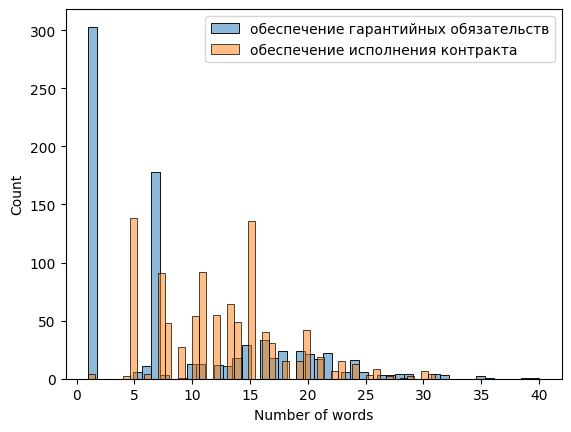

In [ ]:
grouped = train_df.groupby('label')

for label, group in grouped:
    words = group['extracted_text'].apply(lambda x : len(x.split(" ")))
    sns.histplot(words, bins=50, alpha=0.5, label=label)
plt.legend()
plt.xlabel("Number of words")
plt.show()

Видим один большой пик для "Обеспечение гарантийных обязательств", словно это фрагмент, соответствующий одному шаблону.
Первый пик не считается, ибо это следствие пустой строки для пустых фрагментов

Для "Обеспечение исполнения контракта" все не так однозначно. Посмотрим на примеры фрагментов, соответствующих синему пику

In [ ]:
temp = train_df[train_df["label"] == "обеспечение гарантийных обязательств"].apply(lambda x: len(x["extracted_text"].split(" ")), axis=1)
temp.value_counts()[:5]

1     303
7     178
16     33
15     29
19     24
dtype: int64

In [ ]:
counter = 0
for value in train_df[train_df["label"] == "обеспечение гарантийных обязательств"].extracted_text:
  if (len(value.split(" ")) == 7):
    print(value)
    counter+=1
  if counter == 10: # ограничимся 10 значениями
    break

Размер обеспечения гарантийных обязательств 1597.60 Российский рубль
Размер обеспечения гарантийных обязательств 11599.38 Российский рубль
Размер обеспечения гарантийных обязательств 2177.13 Российский рубль
Размер обеспечения гарантийных обязательств 554.00 Российский рубль
Размер обеспечения гарантийных обязательств 265.00 Российский рубль
Размер обеспечения гарантийных обязательств 946800.00 Российский рубль
Размер обеспечения гарантийных обязательств 946800.00 Российский рубль
Размер обеспечения гарантийных обязательств 946800.00 Российский рубль
Размер обеспечения гарантийных обязательств 54182.46 Российский рубль
Размер обеспечения гарантийных обязательств 54182.46 Российский рубль


Шаблон обнаружен. Давайте еще посмотрим на шаблоны пиков для желтой гистограммы для метки "обеспечение исполнения контракта"

In [ ]:
temp = train_df[train_df["label"] == "обеспечение исполнения контракта"].apply(lambda x: len(x["extracted_text"].split(" ")), axis=1)
temp.value_counts()[:5]
del temp

In [ ]:

l = [5,15,11,7] # самые выделяющиеся
for value in train_df[train_df["label"] == "обеспечение исполнения контракта"].extracted_text:
  if (len(value.split(" ")) in l):
    print(value)
    l.remove(len(value.split(" ")))
  if len(l) == 0:
    break

Размер обеспечения исполнения контракта 6593.25 Российский рубль
Размер обеспечения исполнения контракта 10.00%
Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта
Обеспечение исполнения Контракта устанавливается в размере 5 процентов от Цены Контракта.


### Шаблоны:
- Размер обеспечения исполнения контракта ***%
- Размер обеспечения исполнения контракта *** Российский рубль
- Размер обеспечение исполнения контракта устанавливается от *** % до *** % начальной (максимальной) цены контракта
- Обеспечение исполнения Контракта устанавливается в размере *** процентов от Цены Контракта.

# Глубокий анализ подходящих фрагментов и работа со spacy

Продолжим исследовать. Первым делом я хочу попробовать провести синтаксический и морфологический анализ через spacy и решить задачу используя данную библиотеку. Для удобства, для этой секции я оставлю только строки с непустым значением вытащенного фрагмента, так как сейчас цель не научить модель искать нужные фрагменты, а понять, какие фрагменты по структуре нам подходят.

In [ ]:
train_df_spacy = train_df[train_df["extracted_text"] != ''].drop(["answer_start", "answer_end"], axis=1)
train_df_spacy.head()

,id,text,label,extracted_text
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 6593.2...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,Поставщик должен предоставить обеспечение испо...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%


Проверим мою теорию, что каждый из извлеченных фрагментов представляет собой целое предложение, а не кусок из него. Для этого просто посмотрим на то, у всех ли фрагментов первая буква - большая, а в конце стоит точка. Документ официальный, так что очевидно предложение не начнется с маленькой буквы и не закончится воскл. знаком или смайликом)

In [ ]:
for text in train_df_spacy.extracted_text:
  if text[-1] not in [".", "?", "!"]:
    print("данный фрагмент не имеет точки в конце:", text)
    break;
for text in train_df_spacy.extracted_text:
  if not text[0].isupper():
    print("данный фрагмент не начинается с заглавной буквы:", text)
    break;

данный фрагмент не имеет точки в конце: Размер обеспечения исполнения контракта 6593.25 Российский рубль
данный фрагмент не начинается с заглавной буквы: таким участником обеспечения исполнения контракта в размере, превышающем в 1,5 раза размер обеспечения исполнения контракта, указанный в извещении, но не менее чем 10 процентов от начальной (максимальной) цены контракта


Значит фрагменты не всегда полноценные предложения. Дальше разберемся с каждой меткой отдельно

#2. Углубимся. Разберемся с "обеспечением гарантийных обязательств"
[Назад вверх](#scrollTo=9XBkY-v3_bc-)

Посмотрим на самые часто встречающиеся слова в нужным нам фрагментах

In [ ]:
train_df_spacy_garant = train_df_spacy[train_df_spacy["label"] == "обеспечение гарантийных обязательств"]

In [ ]:
counter = Counter()

for text in train_df_spacy_garant.extracted_text:
  words = [analyzer.parse(word)[0].normal_form for word in text.split(" ") if re.fullmatch("[а-яА-Яa-zA-Z]*", word) is not None]
  counter.update(words)


In [ ]:
train_df_spacy_garant.shape[0]

508

In [ ]:
counter.most_common(20)

[('обеспечение', 545),
 ('гарантийный', 536),
 ('размер', 480),
 ('обязательство', 471),
 ('цена', 268),
 ('рубль', 248),
 ('начальный', 231),
 ('от', 204),
 ('составлять', 194),
 ('российский', 176),
 ('в', 167),
 ('что', 118),
 ('исполнение', 87),
 ('договор', 71),
 ('контракт', 68),
 ('устанавливаться', 57),
 ('не', 55),
 ('процент', 47),
 ('по', 36),
 ('и', 36)]

Видим, что непустых строк 508, а некоторые слова встречаются >508 раз. В теории может быть такое, что формы слов "обеспечение" и "гарантиный" встречаются в каждом фрагменте. Проверим это, а также сразу посмотрим на формы этих слов, что встречаются в фрагментах.

In [ ]:
counter = Counter()
ob_count = 0
gar_count = 0
for text in train_df_spacy_garant.extracted_text:
  words = [word for word in text.split(" ") if re.fullmatch("[а-яА-Яa-zA-Z]*", word) is not None]
  gar_bool = False
  ob_bool = False
  for word in words:
    if analyzer.parse(word)[0].normal_form == "обеспечение":
      counter.update([word])
      ob_bool=True
    elif analyzer.parse(word)[0].normal_form == "гарантийный":
      counter.update([word])
      gar_bool=True
  if gar_bool:
    gar_count+=1
  if ob_bool:
    ob_count+=1
ob_count, gar_count, counter.most_common(20)

(508,
 508,
 [('гарантийных', 522),
  ('обеспечения', 408),
  ('Обеспечение', 77),
  ('обеспечение', 46),
  ('обеспечению', 7),
  ('гарантийного', 6),
  ('обеспечении', 6),
  ('Гарантийные', 3),
  ('Гарантийное', 3),
  ('Гарантийных', 1),
  ('гарантийный', 1),
  ('обеспечением', 1)])

Отлично. Видим, что оба этих слова встречаются в абсолютно всех фрагментов в какой-либо форме хотя бы раз.
Также видим, что каждый фрагмент содержит в разных падежах слова "гарантийный" и "обеспечение". Причем, гарантийный в предложении почти всегда имеет одну функцию, а "обеспечение" представлено в разных, так как оно встречается как в именительном падеже(роль подлежащего), так и в, как пример, творительном падеже, что уже роль дополнения.
В числе популярных слов имеется слово "размер"

Посмотрим на фрагменты без слова "обязательство" и форм

In [ ]:
for text in train_df_spacy_garant.extracted_text:
  words = [analyzer.parse(word)[0].normal_form for word in text.split(" ") if re.fullmatch("[а-яА-Яa-zA-Z]*", word) is not None]
  if "обязательство" not in words:
    print(text)

Размер обеспечения гарантийных обязательств, предусмотренных Контрактом, составляет 1 (один) процент от начальной (максимальной) цены контракта.
В соответствии с требованиями извещений об электронном аукционе Размер обеспечения гарантийных обязательств: 0,00 рублей.
Размер обеспечения гарантийных обязательств, предусмотренных Контрактом, составляет 30 (тридцать) процентов от начальной (максимальной) цены контракта.
Размер обеспечения гарантийных обязательств: – предусмотрен, и составляет 10 % от НМЦК, что составляет 135 244 (сто тридцать тысяч двести сорок четыре) рубля 20 копеек.
В соответствии с требованиями извещений об электронном аукционе Размер обеспечения гарантийных обязательств: 0,00 рублей. Доля: 0,00 % от начальной (максимальной) цены контракта
Размер обеспечения гарантийных обязательств: 1% от начальной (максимальной) цены контракта (максимального значения цены контракта)
В соответствии с требованиями извещений об электронном аукционе Размер обеспечения гарантийных обязател

Видим, что возникла небольшая проблема у библиотеки и на самом деле все фрагменты содержат слово "обязательства". Посмотрим на фрагменты без слова "размер"

In [ ]:
for text in train_df_spacy_garant.extracted_text:
  words = [analyzer.parse(word)[0].normal_form for word in text.split(" ") if re.fullmatch("[а-яА-Яa-zA-Z]*", word) is not None]
  if "размер" not in words:
    print(text)

Обеспечение гарантийных обязательств 5% от НМЦК.
Заказчиком установлено требование обеспечения исполнения договора и (или) обеспечения исполнения гарантийных обязательств 5% от начальной (максимальной) цены договора, что составляет 89 649
Обеспечение гарантийных обязательств по Договору Устанавливается 5% от начальной максимальной цены договора
Обеспечение гарантийных обязательств по Договору Устанавливается 5% от начальной максимальной цены договора- 27 400,00 (Двадцать семь тысяч четыреста) рублей 00 копеек
Обеспечение гарантийных обязательств (1% от НМЦК)
Поставщик предоставляет обеспечение гарантийных обязательств в форме -------, на сумму 00 рублей 00 копеек.
Подрядчик предоставляет обеспечение гарантийных обязательств в размере: 93 191,85 (девяносто три тысячи сто девяносто один руб. 85 коп.) рублей (1% начальной (максимальной) цены контракта).
Сумма обеспечения исполнения гарантийных обязательств по контракту составляет: 300 000 (Триста тысяч) рублей 00 копеек.
Требование к обес

Посмотрим на окружение этих фрагментов. Я взял без кода случайный пример из тренировочного набора. Вытащенный фрагмент выглядит так: **Размер обеспечения гарантийных обязательств 560023.30 Российский рубль**.

Окружение выглядит так: **Обеспечение гарантийных обязательств Требуется обеспечение гарантийных обязательств Размер обеспечения гарантийных обязательств 560023.30 Российский рубль Порядок предоставления обеспечения гарантийных обязательств, требования к обеспечению Исполнение контракта**

И на примерах сверху, и тут, видно, что нужные нам фрагменты соответствуют двум "общим" шаблонам.
1. Фрагмент где написано, что обеспечение не установлено
2. Фрагменты, где указана как-либо денежная сумма, связанная с обеспечением и соответствующие ключевые слова: сумма, размер, цена, %, рублей и так далее.

Последняя вещь - это проверка окружения для фрагментов, будто вытащенных из предложения, контекста.
# Пример 1. ID: 941320396
Фрагмент: **взамен ранее предоставленного обеспечения гарантийных обязательств новое обеспечение гарантийных обязательств.**

Окружение фрагмента: **Поставщик вправе изменить способ обеспечения гарантийных обязательств и (или) предоставить Заказчику взамен ранее предоставленного обеспечения гарантийных обязательств новое обеспечение гарантийных обязательств**

Видим, что данный фрагмент лучше выглядит в виде полноценного предложения. Также видим, что этот пример, в отличие от других, не связан с деньгами, а главное, не содержит конкретных цифр.

# Пример 2. ID: 852298687
Фрагмент: **Обеспечение исполнения договора, гарантийных обязательств.**

Окружение: **Обеспечение исполнения договора, гарантийных обязательств.  Способ обеспечения исполнения....**

Здесь я не вставил все, что было после вытащенного фрагмента. Суть в том, что об гарантийных обязательствах там ничего не сказано, и как фрагмент было вытащено это. Хотя в остальных случаях, когда в тексте есть конкретика про размер, подобного рода "заголовок" не вытаскивается.

# Пример 3 доказывающий пример 2. ID: 948128188
Фрагмент: **Установлен Размер обеспечения гарантийных обязательств: 10 % от начальной (максимальной) цены договора, что составляет 19 953**

Окружение: **Размер обеспечения гарантийных обязательств Установлен Размер обеспечения гарантийных обязательств: 10 % от начальной (максимальной) цены договора, что составляет 19 953 (Девятнадцать тысяч девятьсот пятьдесят три) рубля 33 копейки**

Видим, что здесь тоже есть заголовок про гар. обязательства, но он не включен, как и в других фрагментах. Также видим, что фрагмент обрезан, причем в важном месте. Здесь также стоило бы выделить все предложение, что я и буду делать.

Также заметим еще важную вещь, что здесь проявилась проблема не идеального тренировочного набора. Некоторые предложения не разделены корректно, заголовки не отделены точкой. Эт

# Выводы:
- Можно выделять все предложение, так будет часто правильнее
- Почти все фрагменты связаны с деньгами, времени и прочим, причем включают в себя конкретные цифры. Небольшая часть это не соблюдает, возможно это выбросы

Проверим, сколько фрагментов содержит цифры и глянем на те, что не содержат

In [ ]:
count = 0
for text in train_df_spacy_garant.extracted_text:
  if re.fullmatch(".*\d.*", text):
    count+=1
  else:
    print(text)
  
print(count)
del count

Размер обеспечения гарантийных обязательств не установлен.
Обеспечение гарантийных обязательств предоставляется Поставщиком Заказчику не позднее даты
Обеспечение возврата аванса и/или гарантийных обязательств: Установлено.
Обеспечение исполнения договора, гарантийных обязательств.
Обеспечение гарантийных обязательств: Не установлено
Обеспечение гарантийных обязательств: Не установлено
Обеспечение гарантийных обязательств: Не установлено
взамен ранее предоставленного обеспечения гарантийных обязательств новое обеспечение гарантийных обязательств.
если Заказчиком установлено требование обеспечения исполнения договора и/или обеспечения исполнения гарантийных обязательств.
Обеспечение гарантийных обязательств: Не установлено
взамен ранее предоставленного обеспечения гарантийных обязательств новое обеспечение гарантийных обязательств.
Обеспечение гарантийных обязательств: Не установлено
взамен ранее предоставленного обеспечения гарантийных обязательств новое обеспечение гарантийных обязател

Здорово. Видим, что почти все фрагменты содержат цифры(как и говорилось ранее), либо упоминают, что обеспечение не установлено (**используя конкретное словосочетание "не установлено" и его формы). Также есть фраза "взамен ранее предоставленного обеспечения гарантийных обязательств новое обеспечение гарантийных обязательств."

Используя spacy, начнем анализировать синтаксическую роль слов "обеспечение" и "гарантийный", в целом проанализируем фрагменты

Начнем с того, что просто изобразим dependancy graph для некоторых фрагментов. Я все еще работаю с меткой "обеспечение гарантийных обязательств"

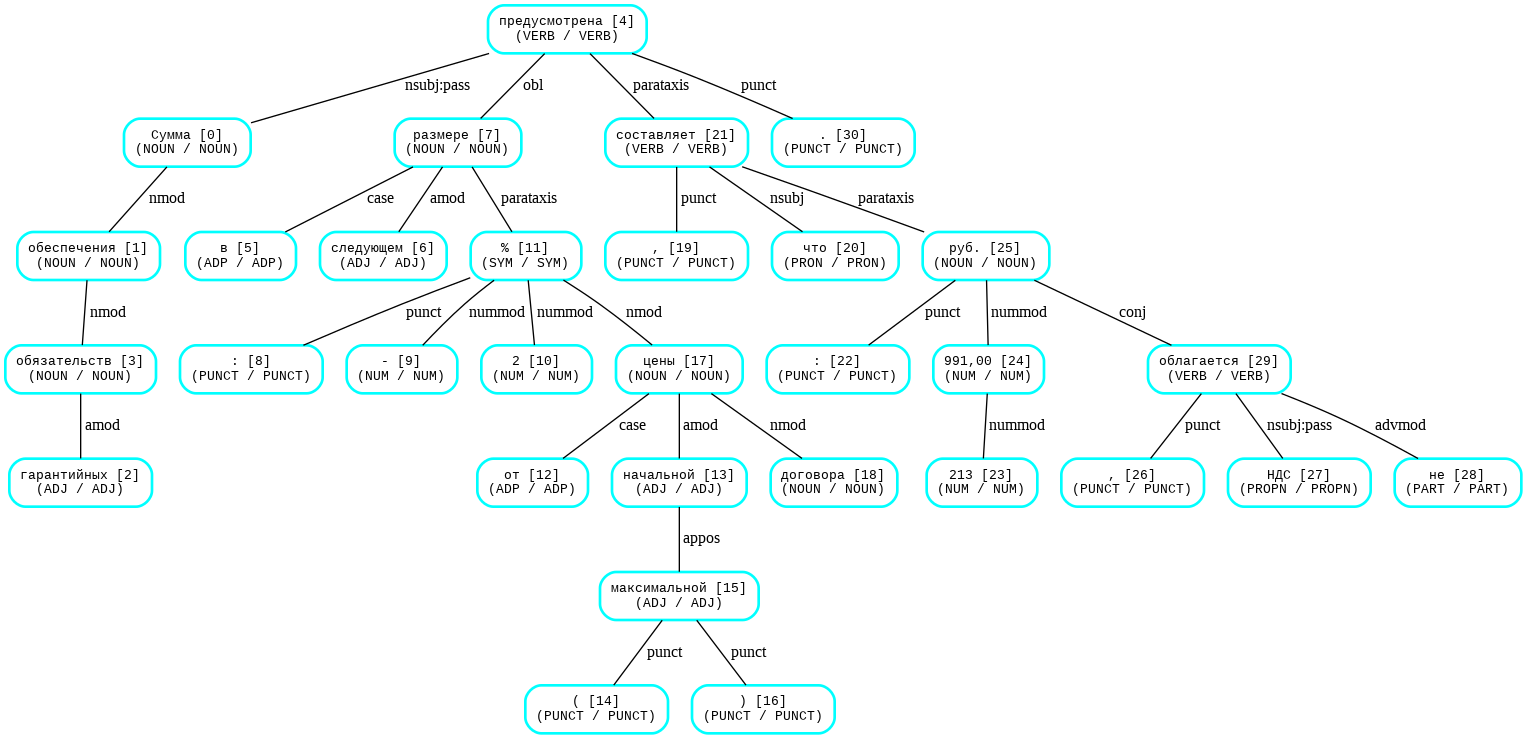

In [ ]:
doc = nlp("Сумма обеспечения гарантийных обязательств предусмотрена в следующем размере: - 2 % от начальной (максимальной) цены договора, что составляет: 213 991,00 руб., НДС не облагается.")
png = visualise_spacy_tree.visualise_spacy_tree.create_png(doc)
display(Image(png))
# тут есть и время, и размер в процентах

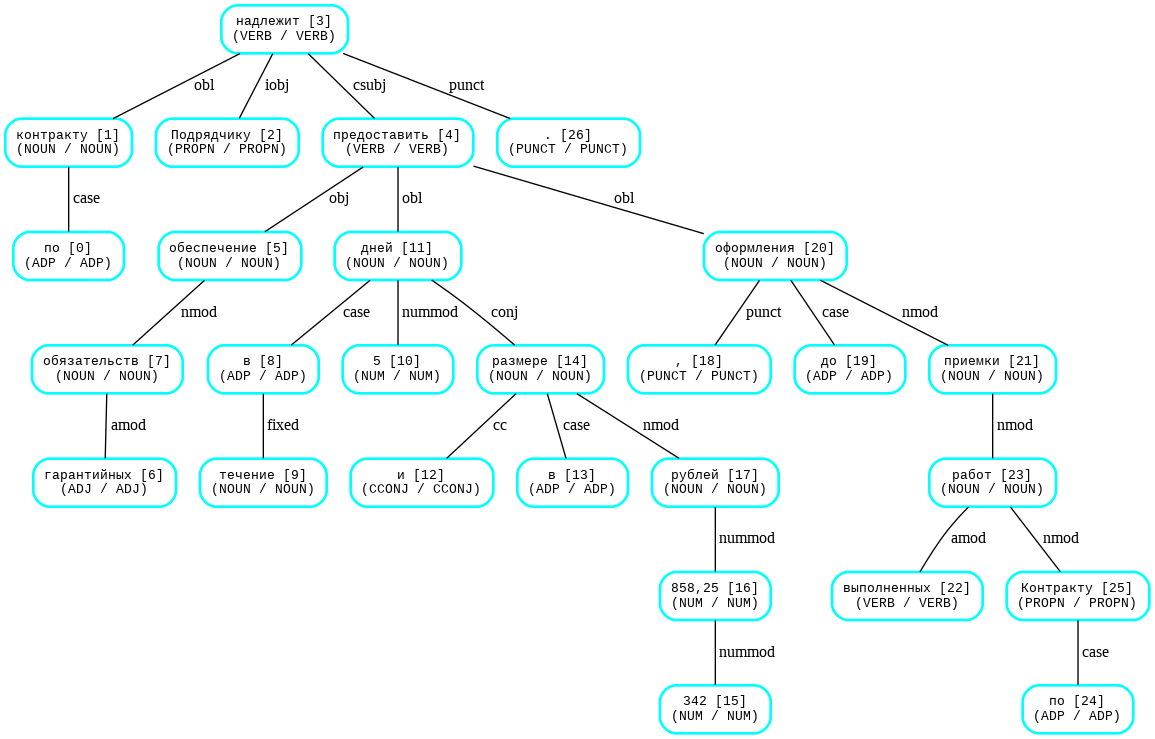

In [ ]:
doc = nlp("по контракту Подрядчику надлежит предоставить обеспечение гарантийных обязательств в течение 5 дней и в размере 342 858,25 рублей, до оформления приемки выполненных работ по Контракту.")
png = visualise_spacy_tree.visualise_spacy_tree.create_png(doc)
display(Image(png))

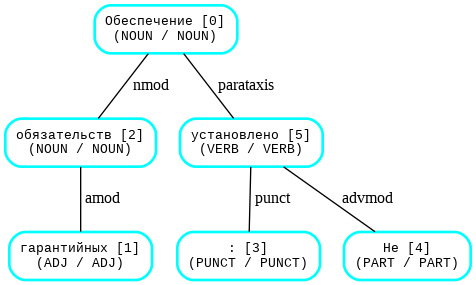

In [ ]:
doc = nlp("Обеспечение гарантийных обязательств: Не установлено")
png = visualise_spacy_tree.visualise_spacy_tree.create_png(doc)
display(Image(png))
# фраза что обеспечения нет. Включает в себя двоеточие

Далее идет один важный случай. Он особен тем, что показывает проблему тренировочного(и, возможно, тестового) набора: отсутствие точек в некоторых местах где они должны быть. Чаще всего это ситуации когда не отделены заголовки по типу "Размер обеспечения гарантийных обязательств" как в примере ниже. Обычно документы в трен. наборе не содержат заголовков, но иногда встречаются. 

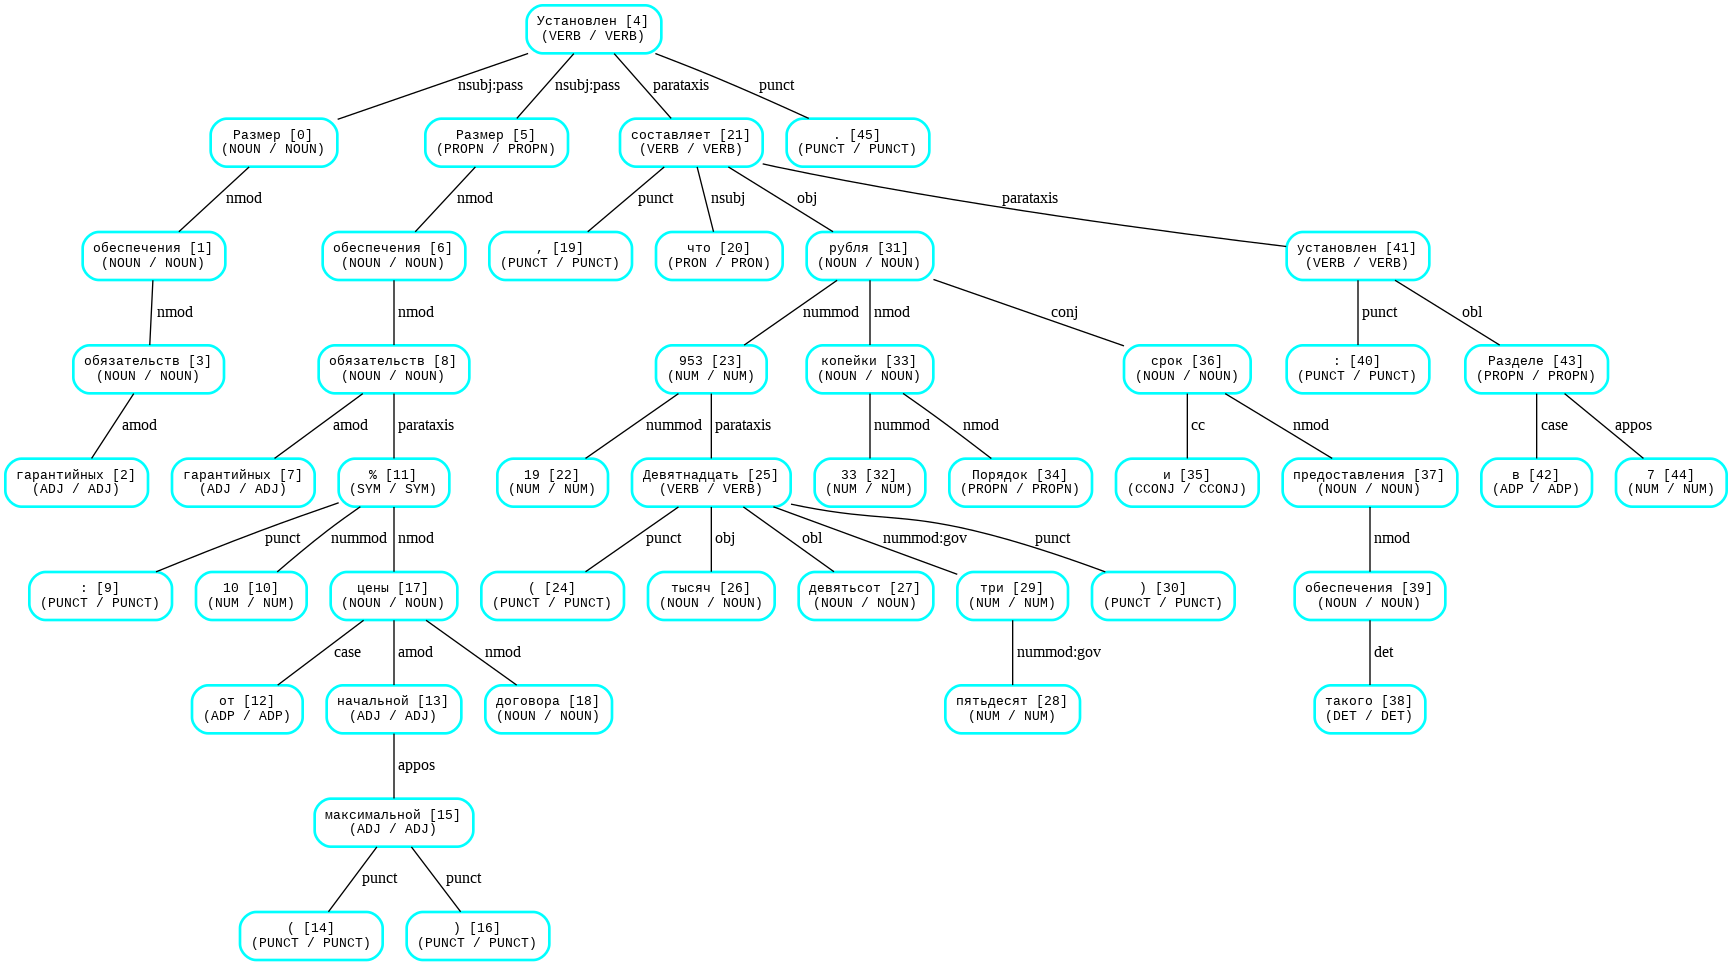

In [ ]:
doc = nlp("Размер обеспечения гарантийных обязательств Установлен Размер обеспечения гарантийных обязательств: 10 % от начальной (максимальной) цены договора, что составляет 19 953 (Девятнадцать тысяч девятьсот пятьдесят три) рубля 33 копейки Порядок и срок предоставления такого обеспечения: установлен в Разделе 7.")
png = visualise_spacy_tree.visualise_spacy_tree.create_png(doc)
display(Image(png))

Выведем на экран все главные слова для слова "обеспечение" (такие как размер, сумма), если это слово не ROOT.

In [ ]:
matcher = spacy.matcher.DependencyMatcher(nlp.vocab)
pattern = [
  {
      "RIGHT_ID": "main", # главное слово для нас
      "RIGHT_ATTRS": {} 
  },
  {
      "LEFT_ID": "main",
      "REL_OP": ">", # ближайший ребенок(зависимое слово)
      "RIGHT_ID": "obespechenie_word", # Зависимое слово
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"}
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">", # ближайший ребенок(зависимое слово)
      "RIGHT_ID": "obyazatelstvo_word",
      "RIGHT_ATTRS": {"LEMMA": "обязательство",
                      "DEP": "nmod"} 
  },
  {
      "LEFT_ID": "obyazatelstvo_word",
      "REL_OP": ">", # ближайший ребенок(зависимое слово)
      "RIGHT_ID": "garant_word",
      "RIGHT_ATTRS": {"LEMMA": "гарантийный",
                      "DEP": "amod"} # прилагательное
  }
]
matcher.add("main", [pattern])

In [ ]:
counter = Counter()
for doc in nlp.pipe(train_df_spacy_garant.extracted_text):
  matches = matcher(doc)
  for match_id, token_ids in matches:
    id = token_ids[0]
    counter.update([doc[id].lemma_])
    
print(counter.most_common(20))

[('размер', 324), ('устанавливаться', 37), ('предоставить', 15), ('предоставлять', 12), ('предоставляться', 6), ('установить', 6), ('сумма', 6), ('представляться', 6), ('предоставление', 6), ('обеспечение', 4), ('требование', 3), ('представлять', 2), ('гарантия', 2), ('экземпляр', 1), ('предусмотреть', 1), ('представить', 1), ('преставление', 1), ('требоваться', 1), ('связать', 1)]


#2.5. Подготовка spacy
[Назад вверх](#scrollTo=9XBkY-v3_bc-)

Внесем некоторые изменения в образование токенов, предложений

Так как исходный докуменет менять не стоит, не будем ставить точки, а изменим правило деления на предложения и добавим разные особые случаи при токенизации

Начнем с того, что иногда предложения начинаются или заканчиваются на цифры из списков(по типу 1.2.Some text). Когда нет пробела между цифрами и текстом, они не делятся на токены и этот случай нам нужно обработать самостоятельно. Сделано будет путем добавления нового префикса в токенайзер

In [ ]:
prefixes = nlp.Defaults.prefixes + [r'''^\d{1,2}\.(\d{1,2}\.){0,2}''',]
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
nlp.tokenizer.prefix_search = prefix_regex.search

Теперь, когда нумерация отделена от предложений, нужно проверить не сломалось ли ничего и работает ли правильно рег. выражение. Для этого я выведу все токены, которые соответствуют этому шаблону на небольшом участке трен. набора

In [ ]:
counter = Counter()
for text in train_df[:100].text:
  doc = nlp(text)
  for token in doc:
    if re.fullmatch("^\d{1,2}\.(\d{1,2}\.){0,2}", token.text) is not None:
      counter.update([token.text])
counter.most_common(20)

[('0.', 78),
 ('05.04.', 41),
 ('6.', 39),
 ('8.1.', 22),
 ('8.2.', 21),
 ('6.1.', 20),
 ('10.', 16),
 ('8.', 15),
 ('1.', 13),
 ('7.', 11),
 ('5.', 10),
 ('9.', 10),
 ('04.06.', 10),
 ('9.1.', 6),
 ('08.11.', 6),
 ('7.1.', 6),
 ('8.3.', 6),
 ('10.1.', 6),
 ('13.07.', 5),
 ('72.', 4)]

Все ок. Далее, чтобы эти номера не были началом предложений, добавим свое правило. Теперь сами цифры и текст после них - отдельные предложения

In [ ]:
@Language.component("set_num_boundary")
def set_num_boundary(doc):
    for token in doc[:-1]:
        if re.fullmatch("^\d{1,2}\.(\d{1,2}\.){0,2}", token.text) is not None:
            if doc[token.i+1].text[0].isupper():
              doc[token.i].is_sent_start = True
              doc[token.i+1].is_sent_start = True
    return doc

nlp.add_pipe("set_num_boundary", before = "parser")

<function __main__.set_num_boundary(doc)>

В тексте встречаются цифры сверху текста, и в сыром виде они обозначаются в виде [footnoteRef:..] и идут без пробела сразу после слов, из-за чего становятся одним общим токеном. Добавим новый суффикс, чтобы обрабатывать корректно эту ситуацию

In [ ]:
suffixes = nlp.Defaults.suffixes + [r'''\[footnoteRef:\d*$''',] 
suffix_regex = spacy.util.compile_suffix_regex(suffixes)
nlp.tokenizer.suffix_search = suffix_regex.search

Избавляемся от этого элемента в предложениях

In [ ]:
@Language.component("set_footnoteref_boundary")
def set_footnoteref_boundary(doc):
    for token in doc[:-1]:
        if token.text.startswith("[footnoteRef:"):
            doc[token.i].is_sent_start = True
    return doc

nlp.add_pipe("set_footnoteref_boundary", before = "parser")

<function __main__.set_footnoteref_boundary(doc)>

Модель spacy для русского языка не справляется с ситуациями, когда сокращение является и концом предложения, так что исправим ситуацию для конкретного сокращения "руб."

In [ ]:

@Language.component("set_rub_boundary")
def set_rub_boundaries(doc):
    for token in doc[:-1]:
        if token.text.endswith("руб.") and doc[token.i + 1].text[0].isupper():
            doc[token.i + 1].is_sent_start = True
    return doc

nlp.add_pipe("set_rub_boundary", before = "parser")

<function __main__.set_rub_boundaries(doc)>

Дальше идет обработка заранее отобранных заголовках. Суть кода в том, чтобы данные заголовки вынести в отдельное предложение, путем нахожденияих в тексте и установки флага нового предложения на первом токене самого заголовка, и первом токене текста после заголовка.
Заголовки уже прописаны для обеих меток

In [ ]:
titles_patterns = [ # Заголовки отобраны заранее
    [{"ORTH" : "Порядок"}, {"ORTH" : "обеспечения"}, {"ORTH" : "исполнения"}, {"ORTH" : "контракта"}, {"ORTH" : ","}, {"ORTH" : "требования"}, {"ORTH" : "к"}, {"ORTH" : "обеспечению"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Размер"}, {"ORTH" : "обеспечения"}, {"ORTH" : "гарантийных"}, {"ORTH" : "обязательств"},{"ORTH" : {"REGEX" : "^[А-Я]\w*$"}}],
    [{"ORTH" : "Сумма"}, {"ORTH" : "обеспечения"}, {"ORTH" : "исполнения"}, {"ORTH" : "контракта"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Обеспечение"}, {"ORTH" : "заявки"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Вид"}, {"ORTH" : "требования"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Дополнительная"}, {"ORTH" : "информация"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Обеспечение"}, {"ORTH" : "исполнения"}, {"ORTH" : "контракта"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Перечень"}, {"ORTH" : "прикрепленных"}, {"ORTH" : "документов"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Срок"}, {"ORTH" : "обеспечения"}, {"ORTH" : "исполнения"}, {"ORTH" : "Контракта"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Требуется"}, {"ORTH" : "обеспечение"}, {"ORTH" : "исполнения"}, {"ORTH" : "контракта"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Порядок"}, {"ORTH" : "предоставления"}, {"ORTH" : "обеспечения"}, {"ORTH" : "исполнения"}, {"ORTH" : "контракта"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Порядок"}, {"ORTH" : "предоставления"}, {"ORTH" : "обеспечения"}, {"ORTH" : "гарантийных"}, {"ORTH" : "обязательств"}, {"ORTH" : ","}, {"ORTH" : "требования"}, {"ORTH" : "к"}, {"ORTH" : "обеспечению"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Требуется"}, {"ORTH" : "обеспечение"}, {"ORTH" : "гарантийных"}, {"ORTH" : "обязательств"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Размер"}, {"ORTH" : "обеспечения"}, {"ORTH" : "гарантийных"}, {"ORTH" : "обязательств"}, {"ORTH" : "и"}, {"ORTH" : "порядок"}, {"ORTH" : "предоставления"}, {"ORTH" : "обеспечения"}, {"ORTH" : "гарантийных"}, {"ORTH" : "обязательств"}, {"ORTH" : ","}, {"ORTH" : "требования"}, {"ORTH" : "к"}, {"ORTH" : "такому"}, {"ORTH" : "обеспечению"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
    [{"ORTH" : "Обеспечение"}, {"ORTH" : "гарантийных"}, {"ORTH" : "обязательств"},{"ORTH" : {"REGEX" : "[А-Я].*"}}],
  ]
titles = [
    "Порядок обеспечения исполнения контракта, требования к обеспечению",
    "Размер обеспечения гарантийных обязательств",
    "Сумма обеспечения исполнения контракта",
    "Обеспечение заявки",
    "Вид требования",
    "Дополнительная информация",
    "Обеспечение исполнения контракта"
    "Перечень прикрепленных документов",
    "Срок обеспечения исполнения контракта",
    "Требуется обеспечение исполнения контракта",
    "Порядок предоставления обеспечения исполнения контракта",
    "Порядок предоставления обеспечения гарантийных обязательств, требования к обеспечению",
    "Требуется обеспечение гарантийных обязательств",
    "Размер обеспечения гарантийных обязательств и порядок предоставления обеспечения гарантийных обязательств, требования к такому обеспечению",
    "Обеспечение гарантийных обязательств",
]

In [ ]:
@Language.component("set_titles_boundary")
def set_title_boundaries(doc : spacy.tokens.Doc):
    matcher = spacy.matcher.Matcher(nlp.vocab)
    matcher.add("Titles", titles_patterns)
    matches = matcher(doc)
    for match_id, start_idx, end_idx in matches:  
      start = False # индикатор нашли ли мы начало заголовка
      end = False # индикатор нашли ли мы начало предложения после заголовка
      for token in doc:
        if token.i == start_idx:
          doc[token.i].is_sent_start = True
          start = True
        elif token.i+1 == end_idx:
          doc[token.i].is_sent_start = True
          end = True

        if start and end:
          break

    return doc

nlp.add_pipe("set_titles_boundary", before = "parser")

<function __main__.set_title_boundaries(doc: spacy.tokens.doc.Doc)>

Также дополнительно сделаем еще один компонент, который будет выделять в новое предложение все, что начинается с "Размер", "Обеспечение", "Сумма", "Срок", "Порядок", "Требование", "Положение", "Если"
Нельзя просто сделать так, чтобы любое слово с большой буквы означало начало предложения, ибо много слов которые начинаются с большой буквы но началами предложения не являются. Так что были отобраны слова, которые часто встречаются вокруг нужных нам фрагментов и которые не начинаются с большой буквы по иным причинам кроме начала предложения.

In [ ]:
@Language.component("set_razmer_boundary")
def set_razmer_boundaries(doc : spacy.tokens.Doc):
      for token in doc:
        if token.text[0].isupper() and analyzer.parse(token.text)[0].normal_form in ["размер","обеспечение","если", "сумма", "порядок", "срок","требование", "положение"]:
          doc[token.i].is_sent_start = True

      return doc

nlp.add_pipe("set_razmer_boundary", before = "parser")

<function __main__.set_razmer_boundaries(doc: spacy.tokens.doc.Doc)>

#3. Теперь перейдем к уже реализации самого поиска фрагментов. 
[Назад вверх](#scrollTo=9XBkY-v3_bc-)

Главная идея: вытаскивать текст я собираюсь по предложениям, так как каждое дерево зависимостей обычно обознает одно предложение, и так удобно работать, учитывая, что spacy предоставляет инструменты для выделения предложений. 
Сначала модель будет пытаться найти в тексте предопределенный шаблон (один из). Затем, если какой-нибудь шаблон не найдется, она попробует найти текст, соответствующим одному из следующих "регулярных" выражений:
- ОБЩЕЕ УСЛОВИЕ, которое должно выполняться всегда: предложение содержит в любой форме фразу "обеспечение гарантийных обязательств"
- Предложение содержит формы слова "установлен" к слову "обеспечение" или словам над ним в дереве
- Предложение содержит в себе числа в виде слов или цифр и последующий знак процента или упомянание рубля

*Пометка*: В список предопределенных шаблонов были выбраны только те, которые попадаются довольно часто в трен. наборе и которые действительно являются шаблонами, а не редкими примерами.

In [ ]:
#@title Шаблоны
phrases_garant = [
    "Размер обеспечения гарантийных обязательств [.,\d]* Российский рубль[.]?",
    "обеспечение исполнения гарантийных обязательств в размере не менее [,.\d]* %",
    "Размер обеспечения гарантийных обязательств составляет [\d]*% начальной (максимальной) цены контракта.",
    "Обеспечение гарантийных обязательств устанавливается в размере [\d]*% от начальной (максимальной) цены контракта.",
    "Размер обеспечения гарантийных обязательств составляет [_]*рублей, что составляет [\d]*% от начальной (максимальной) цены Контракта.",
]

In [ ]:
#@title Паттерны
first_pattern = [ # обеспечение главное, есть слово установлен
  {
      "RIGHT_ID": "obespechenie_word", 
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"}
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">>", # гдето в дереве у "обеспечение". сделано для опознавания фраз типа "обеспечение исполнения гарантийных обязательств"
      "RIGHT_ID": "obyazatelstvo_word",
      "RIGHT_ATTRS": {"LEMMA": "обязательство"} # 
  },
  {
      "LEFT_ID": "obyazatelstvo_word",
      "REL_OP": ">", 
      "RIGHT_ID": "garant_word",
      "RIGHT_ATTRS": {"LEMMA": "гарантийный",
                      "DEP": "amod"} # прилагательное
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">", # привязано к "обеспечение"
      "RIGHT_ID": "ustanovlen_word",
      "RIGHT_ATTRS": {"LEMMA": "установить"}
  }
]
second_pattern = [ # обеспечение главное, имеются цифры связанные с деньгами или процентами
  {
      "RIGHT_ID": "obespechenie_word", 
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"} 
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">>", # гдето в дереве у "обеспечение". сделано для опознавания фраз типа "обеспечение исполнения гарантийных обязательств"
      "RIGHT_ID": "obyazatelstvo_word",
      "RIGHT_ATTRS": {"LEMMA": "обязательство"} 
  },
  {
      "LEFT_ID": "obyazatelstvo_word",
      "REL_OP": ">", 
      "RIGHT_ID": "garant_word",
      "RIGHT_ATTRS": {"LEMMA": "гарантийный",
                      "DEP": "amod"} # прилагательное
  },
  { # Число где-то в дереве
      "LEFT_ID": "obespechenie_word", 
      "REL_OP": ".*", 
      "RIGHT_ID": "number",
      "RIGHT_ATTRS": {"POS": "NUM"}
  }, # после которого идет процент или рубль
  {   "LEFT_ID": "number",
      "REL_OP": ".", # следующий токен 
      "RIGHT_ID": "to_number",
      "RIGHT_ATTRS": {"LEMMA" : {"IN" : ["рубль", "%", "руб.", "руб", "процент"]}}
  }
]
third_pattern = [ # обеспечение зависимое, есть форма "установить"
  {
      "RIGHT_ID": "main", # root
      "RIGHT_ATTRS": {} 
  },
  {
      "LEFT_ID": "main",
      "REL_OP": ">>", # ближайший ребенок(зависимое слово)
      "RIGHT_ID": "obespechenie_word", # Зависимое слово
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"}
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">>", # гдето в дереве у "обеспечение". сделано для опознавания фраз типа "обеспечение исполнения гарантийных обязательств"
      "RIGHT_ID": "obyazatelstvo_word",
      "RIGHT_ATTRS": {"LEMMA": "обязательство"}
  },
  {
      "LEFT_ID": "obyazatelstvo_word",
      "REL_OP": ">", 
      "RIGHT_ID": "garant_word",
      "RIGHT_ATTRS": {"LEMMA": "гарантийный",
                      "DEP": "amod"} # прилагательное
  },
  {
      "LEFT_ID": "main",
      "REL_OP": ">", 
      "RIGHT_ID": "ustanovlen_word",
      "RIGHT_ATTRS": {"LEMMA": "установить"}
  }
]
fourth_pattern = [ # обеспечение зависимое, есть цифра
  {
      "RIGHT_ID": "main", # root
      "RIGHT_ATTRS": {} 
  },
  {
      "LEFT_ID": "main",
      "REL_OP": ">>", 
      "RIGHT_ID": "obespechenie_word", 
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"}
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">>",  # где-то в дереве у "обеспечение". сделано для опознавания фраз типа "обеспечение исполнения гарантийных обязательств"
      "RIGHT_ID": "obyazatelstvo_word",
      "RIGHT_ATTRS": {"LEMMA": "обязательство"} 
  },
  {
      "LEFT_ID": "obyazatelstvo_word",
      "REL_OP": ">",
      "RIGHT_ID": "garant_word",
      "RIGHT_ATTRS": {"LEMMA": "гарантийный",
                      "DEP": "amod"} # прилагательное
  },
  { # Число где-то в дереве
      "LEFT_ID": "main", 
      "REL_OP": ".*", 
      "RIGHT_ID": "number",
      "RIGHT_ATTRS": {"POS": "NUM"}
  }, # после которого идет процент или рубль
  {   "LEFT_ID": "number",
      "REL_OP": ".", # следующий токен 
      "RIGHT_ID": "to_number",
      "RIGHT_ATTRS": {"LEMMA" : {"IN" : ["рубль", "%", "руб.", "руб"]}}
  }
]
fifth_pattern = [ # обеспечение зависимое, есть цифра и транскрипция
  {
      "RIGHT_ID": "main", # root
      "RIGHT_ATTRS": {} 
  },
  {
      "LEFT_ID": "main",
      "REL_OP": ">>", 
      "RIGHT_ID": "obespechenie_word", 
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"}
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">>",  # где-то в дереве у "обеспечение". сделано для опознавания фраз типа "обеспечение исполнения гарантийных обязательств"
      "RIGHT_ID": "obyazatelstvo_word",
      "RIGHT_ATTRS": {"LEMMA": "обязательство"} 
  },
  {
      "LEFT_ID": "obyazatelstvo_word",
      "REL_OP": ">",
      "RIGHT_ID": "garant_word",
      "RIGHT_ATTRS": {"LEMMA": "гарантийный",
                      "DEP": "amod"} # прилагательное
  },
  { # Число где-то в дереве
      "LEFT_ID": "main", 
      "REL_OP": ".*", 
      "RIGHT_ID": "number",
      "RIGHT_ATTRS": {"POS": "NUM"}
  }, # после которого идет процент или рубль
  {
      "LEFT_ID": "number", 
      "REL_OP": ".", 
      "RIGHT_ID": "skobka1",
      "RIGHT_ATTRS": {"LEMMA": "("}
  },
  {
      "LEFT_ID": "skobka1", 
      "REL_OP": ".", 
      "RIGHT_ID": "something",
      "RIGHT_ATTRS": {"POS": {"IN" : ["NUM", "PROPN"]}}
  },
  {
      "LEFT_ID": "something", 
      "REL_OP": ".", 
      "RIGHT_ID": "skobka2",
      "RIGHT_ATTRS": {"LEMMA": ")"}
  },
  {
      "LEFT_ID": "skobka2",
      "REL_OP": ".", 
      "RIGHT_ID": "to_number",
      "RIGHT_ATTRS": {"LEMMA" : {"IN" : ["рубль", "%", "руб.", "руб", "процент"]}}
  }
]
sixth_pattern = [ # обеспечение главное, имеются цифры связанные с деньгами или процентами и транскрипция
  {
      "RIGHT_ID": "obespechenie_word", 
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"} 
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">>", # гдето в дереве у "обеспечение". сделано для опознавания фраз типа "обеспечение исполнения гарантийных обязательств"
      "RIGHT_ID": "obyazatelstvo_word",
      "RIGHT_ATTRS": {"LEMMA": "обязательство"}
  },
  {
      "LEFT_ID": "obyazatelstvo_word",
      "REL_OP": ">", 
      "RIGHT_ID": "garant_word",
      "RIGHT_ATTRS": {"LEMMA": "гарантийный",
                      "DEP": "amod"} # прилагательное
  },
  { # Число где-то в дереве
      "LEFT_ID": "obespechenie_word", 
      "REL_OP": ".*", 
      "RIGHT_ID": "number",
      "RIGHT_ATTRS": {"POS": "NUM"}
  }, # после которого идет процент или рубль
  {
      "LEFT_ID": "number", 
      "REL_OP": ".", 
      "RIGHT_ID": "skobka1",
      "RIGHT_ATTRS": {"LEMMA": "("}
  },
  {
      "LEFT_ID": "skobka1", 
      "REL_OP": ".", 
      "RIGHT_ID": "something",
      "RIGHT_ATTRS": {"POS": {"IN" : ["NUM", "PROPN"]}}
  },
  {
      "LEFT_ID": "something", 
      "REL_OP": ".", 
      "RIGHT_ID": "skobka2",
      "RIGHT_ATTRS": {"LEMMA": ")"}
  },
  {
      "LEFT_ID": "skobka2",
      "REL_OP": ".", 
      "RIGHT_ID": "to_number",
      "RIGHT_ATTRS": {"LEMMA" : {"IN" : ["рубль", "%", "руб.", "руб", "процент"]}}
  }
]

In [ ]:
#@title Проверка работы модели (только паттерны) на проблемном тексте
isFragment = False # используется для того, чтобы извлекать лишь один продолжительный фрагмент, а не предложения из разных частей текста
text = "Федеральное государственное бюджетное научное учреждение «Федеральный исследовательский центр Всероссийский институт генетических ресурсов растений имени Н.И. Вавилова» ДОКУМЕНТАЦИЯ ОБ АУКЦИОНЕ В ЭЛЕКТРОННОЙ ФОРМЕ на поставку жатки для уборки кукурузы для нужд вор с таким победителем заключается по цене, увеличенной на 15 процентов от предложенной им цены договора. При исполнении договора, заключенного с участником закупки, в отношении которого Правительством Российской Федерации предоставлен приоритет товаров российского происхождения, работ, услуг, выполняемых, оказываемых российскими лицами, по отношению к товарам, происходящим из иностранного государства, работам, услугам, выполняемым, оказываемым иностранными лицами, не допускается замена страны происхождения товаров, за исключением случая, когда в результате такой замены вместо иностранных товаров поставляются российские товары, при этом качество, технические и функциональные характеристики (потребительские свойства) таких товаров не должны уступать качеству и соответствующим техническим и функциональным характеристикам товаров, указанных в договоре. 32. Критерии и порядок оценки и сопоставления заявок на участие в закупке Не установлены 33. Размер обеспечения гарантийных обязательств Установлен Размер обеспечения гарантийных обязательств: 5 % от начальной (максимальной) цены договора, что составляет 206 650 (Двести шесть тысяч шестьсот пятьдесят) рублей 00 копеек Порядок и срок предоставления такого обеспечения: установлен в Разделе 7. «Проект Договора». Реквизиты счета для внесения обеспечения исполнения договора: Получатель: УФК по г. Санкт-Петербургу (ВИР л/сч 20726У32850) Юридический адрес: 190000, г. Санкт-Петербург, ул. Большая Морская, д. 42, 44, ИНН 7812029408 КПП 783801001 ОКТМО 40303000 р/сч 03214643000000017200 в Северо-Западном ГУ Банка России г. Санкт-Петербург ЕКС 40102810945370000005 БИК ТОФК 014030106 ОКПО 00495651 ОКВЭД 72.19 ОГРН 1027810308206 КБК 00000000000000000510 В платежном поручении в поле «Назначение платежа» указывается (510ВР) «Обеспечение гарантийных обязательств, номер извещения о проведении аукциона в электронной форме» 34. Ограничение участия в определении поставщика (подрядчика, исполнителя) (СМП, СОНО) Не установлено 35. Условия, запреты и ограничения допуска товаров, происходящих из иностранного государства или группы иностранных государств, работ, услу Хлесткина� � � � «08» сентября 2022 г.� � PAGE"
doc = nlp(text)
matcher = spacy.matcher.DependencyMatcher(nlp.vocab)
matcher.add("patterns", [first_pattern, second_pattern, third_pattern, fourth_pattern])

for sentence in doc.sents:
  if sentence.text in titles:
    continue
  doc_sent = sentence.as_doc()
  matches = matcher(doc_sent)
  if isFragment:
    if len(matches) > 0:
      print(sentence)
    else:
      break;
  else:
    if len(matches) > 0:
      print(sentence)
      isFragment = True


Размер обеспечения гарантийных обязательств: 5 % от начальной (максимальной) цены договора, что составляет 206 650 (Двести шесть тысяч шестьсот пятьдесят) рублей 00 копеек


Неплохо. Сделаем функцию для предсказания этой метки

In [ ]:
matcher_garant = spacy.matcher.DependencyMatcher(nlp.vocab)
matcher_garant.add("patterns", [first_pattern, second_pattern, third_pattern, fourth_pattern, fifth_pattern, sixth_pattern])

In [ ]:
def predictGarant (row): # только для соответствующей метки
  text = row["text"]
  predicted_part = {}
  predicted_part["text"] = ['']
  predicted_part["answer_start"] = [0]
  predicted_part["answer_end"] = [0]



  for phrase in phrases_garant:
    result = re.search(phrase, text)
    if result is not None:
      predicted_part["text"] = [result.group(0)]
      predicted_part["answer_start"] = [result.start()]
      predicted_part["answer_end"] = [result.end()]
      row["extracted_part"] = predicted_part
      return row

  isFragment = False
  answer = []
  doc = nlp(text)
  for sentence in doc.sents:
    if len(sentence) > 80: # если предложение очень большое, то лучше на него время не тратить
      continue;
    if sentence.text in titles:
      continue
    doc_sent = sentence.as_doc()
    matches = matcher_garant(doc_sent)
    if isFragment:
      if len(matches) > 0:
        answer.append(sentence.text)
        predicted_part["answer_end"] = [sentence.end_char]
      else:
        break;
    else: # первое подходящее совпадение
      if len(matches) > 0:
        answer.append(sentence.text)
        predicted_part["answer_start"] = [sentence.start_char]
        predicted_part["answer_end"] = [sentence.end_char]
        isFragment = True
  predicted_part["text"] = " ".join(answer)
  row["extracted_part"] = predicted_part
  return row

Далее идет код для просмотра несовпадений предсказания и настоящего фрагмента

In [ ]:
#train_df_garant = train_df[train_df["label"] == "обеспечение гарантийных обязательств"].drop(["answer_start", "answer_end"],axis=1)
#train_df_garant = train_df_garant.apply(predictGarant, axis=1)

In [ ]:
# counter = 0
# for index,row in train_df_garant.iterrows():
#   if row["extracted_text"] != row["predicted_text"]:
#     print("Extracted part:")
#     print(row["extracted_text"])
#     print("Predicted:")
#     print(row["predicted_text"])
#     counter +=1

#4. Теперь разберемся с "обеспечением исполнения контракта"
[Назад вверх](#scrollTo=9XBkY-v3_bc-)

В целом, смысл этой метки такой же. Выводы и подходы к решению и коду будут примерно те же, с небольшими изменениями.

Шаги исследования те же, что с предыдущей меткой. Сначала глянем на частые слова

In [ ]:
train_df_spacy_ispoln = train_df_spacy[train_df_spacy["label"] == "обеспечение исполнения контракта"]
counter = Counter()
for text in train_df_spacy_ispoln.extracted_text:
  words = [analyzer.parse(word)[0].normal_form for word in text.split(" ") if re.fullmatch("[а-яА-Яa-zA-Z]*", word) is not None]
  counter.update(words)
counter.most_common(20)

[('обеспечение', 995),
 ('исполнение', 963),
 ('размер', 888),
 ('контракт', 767),
 ('договор', 636),
 ('цена', 628),
 ('от', 592),
 ('в', 452),
 ('начальный', 448),
 ('составлять', 190),
 ('устанавливаться', 152),
 ('рубль', 132),
 ('не', 117),
 ('установить', 110),
 ('процент', 108),
 ('до', 101),
 ('настоящий', 84),
 ('российский', 82),
 ('что', 64),
 ('поставщик', 62)]

In [ ]:
train_df_spacy_ispoln.shape[0]

984

In [ ]:
counter = Counter()
ob_count = 0
gar_count = 0
for text in train_df_spacy_ispoln.extracted_text:
  words = [word for word in text.split(" ") if re.fullmatch("[а-яА-Яa-zA-Z]*", word) is not None]
  gar_bool = False
  ob_bool = False
  for word in words:
    if analyzer.parse(word)[0].normal_form == "обеспечение":
      counter.update([word])
      ob_bool=True
    elif analyzer.parse(word)[0].normal_form in ["контракт", "договор"]:
      counter.update([word])
      gar_bool=True
  if gar_bool:
    gar_count+=1
  if ob_bool:
    ob_count+=1
ob_count, gar_count, counter.most_common(20)

(976,
 950,
 [('обеспечения', 571),
  ('контракта', 522),
  ('договора', 490),
  ('Контракта', 238),
  ('обеспечение', 202),
  ('Обеспечение', 194),
  ('Договора', 124),
  ('обеспечению', 22),
  ('договор', 9),
  ('Договору', 6),
  ('обеспечении', 6),
  ('контракт', 5),
  ('договору', 5),
  ('Контракт', 1),
  ('Контракту', 1),
  ('Договор', 1),
  ('договором', 1)])

Часто в примерах слово "контракт" заменено словом "документ", поэтому в подсчете они считались как одно слово. Видно, что в отличие от предыдущей метки, в этой метке не все фрагменты содержат что слово "обеспечение", что слово "контракт/договор". Посмотрим фразы без слова "обеспечение"

In [ ]:
for text in train_df_spacy_ispoln.extracted_text:
  words = [analyzer.parse(word)[0].normal_form for word in text.split(" ") if re.fullmatch("[а-яА-Яa-zA-Z]*", word) is not None]
  if "обеспечение" not in words:
    print(text)

Размер обеспечения: 50 % от цены договора на выполнение строительно-монтажных работ
Размер обеспечения: 5 % - 83 649,45 рублей
Размер обеспечения: 5 % - 89 500,00 (восемьдесят девять тысяч пятьсот) рублей 00
В размере 5% от начальной максимальной цены Договора в сумме 15801,15
Размер обеспечения: 10% (Десять процентов) от начальной (максимальной) цены договора
Размер обеспечения: 50 % от цены договора на выполнение строительно-монтажных работ
Размер обеспечения: 50 % от цены договора на выполнение строительно-монтажных работ
Размер обеспечения: 5 % от начальной (максимальной) цены договора.


Видим, что просто библиотека не распознала слово с двоеточием. Spacy с этим справиться, так что ничего страшного. теперь по поводу контракта/договора:

In [ ]:
for text in train_df_spacy_ispoln.extracted_text:
  words = [analyzer.parse(word)[0].normal_form for word in text.split(" ") if re.fullmatch("[а-яА-Яa-zA-Z]*", word) is not None]
  if "контракт" not in words and "договор" not in words:
    print(text)

Размер обеспечения исполнения контракта: 1% от цены контакта
Размер обеспечения исполнения контракта: 5 % от цены контракта, по которой заключается контракт.
Размер обеспечения исполнения контракта: 10% от начальной (максимальной) цены Контракта.
Размер обеспечения исполнения контракта: 5 % от цены контракта.
Размер обеспечения исполнения контракта: 10% от цены контракта.
Размер обеспечения исполнения контракта: 10% от начальной (максимальной) цены Контракта.
Размер обеспечения исполнения контракта: 10% от начальной (максимальной) цены Контракта.
Обеспечение исполнения договора: 5% от начальной (максимальной) цены договора: 11 438,00 руб.
Размер обеспечения: 5 % - 83 649,45 рублей
Размер обеспечения исполнения договора: 30% от НМЦД
Размер обеспечения исполнения договора: 5 (Пять) процентов от начальной (максимальной) цены договора)
Размер обеспечения исполнения договора, срок и порядок его предоставления: 5 % - 7 421,50 (Семь тысяч четыреста двадцать один) руб. 50
Размер обеспечения ис

Видим один шаблон, который не содержит слова контракт/договор: **Размер обеспечения: X % - N рублей**
Остальные содержат, просто опять с двоеточием. Запомнили. Последнее: глянем на фрагменты без "размер"



In [ ]:
for text in train_df_spacy_ispoln.extracted_text:
  words = [analyzer.parse(word)[0].normal_form for word in text.split(" ") if re.fullmatch("[а-яА-Яa-zA-Z]*", word) is not None]
  if "размер" not in words:
    print(text)

Сумма обеспечения контракта составляет 10 % от цены контракта
Обеспечение исполнения Контракта составляет 10% от цены Контракта(цены лота),что составляет_________ (_____
Сумма обеспечения исполнения договора составляет 10 % цены Договора, что составляет __________ (_________________
Заказчиком установлено требование обеспечения исполнения Контракта - 5 % от цены Контракта, что составляет ​​​​​​​​​​​_____________
Установить обеспечения исполнения контракта (от 0,5% до 30%) % обеспечения
Обеспечение исполнения настоящего Контракта предоставляется Поставщиком на сумму 10% от начальной (максимальной) цены Контракта
Исполнитель представляет Заказчику обеспечение исполнения контракта на сумму _______________ рублей __ копеек, эквивалентную 5 (пяти) процентам от начальной (максимальной) цены контракта.
Обеспечение исполнения настоящего Контракта установлено в размере: 10 процентов начальной (максимальной) цены контракта.
Обеспечение исполнения контракта 5% от цены контракта
требования к таком

Как и раньше, все фрагменты связаны с рублями, процентами. Заметим, что не видно фраз, где размер ... не установлен. Таких шаблонов нет?


In [ ]:
count = 0
for text in train_df_spacy_ispoln.extracted_text:
  if re.fullmatch(".*\d.*", text):
    count+=1
  else:
    print(text)
  
print(count)
del count

984


Кажется, что действительно такого здесь нет. в наборе вообще нет фраз без цифр.
Посмотрим на один из нескольких интересных примеров. В нем показано, что иногда фрагменты не содержат все словосочетание из метки. Здесь, например, нет слова исполнение.

In [ ]:
train_df[train_df["id"] == 914041532].extracted_text.iloc[0]

'Размер обеспечения договора 5 % от НМЦ составляет: 4403 руб.75 коп.'

Разбора деревьев далее не будет, ибо суть в целом та же. 

#5. Перейдем к коду поиска фрагментов. 
[Назад вверх](#scrollTo=9XBkY-v3_bc-)

Подход аналогичный: сначала ищем отобраные заранее частые шаблоны, затем при неудаче ищем по паттернам регулярных выражений
Паттерны:
- ОБЩЕЕ УСЛОВИЕ, которое должно выполняться всегда: предложение содержит в любой форме фразу "обеспечение исполнения договора/контракта" или "обеспечение  договора/контракта"
- Предложение содержит в себе числа в виде слов или цифр и последующий знак процента или упомянание рубля

Как видно, шаблон связанный с "установить" был убран, так как не имеет смысла в данном случае


In [ ]:
phrases_ispoln = [
    "Размер обеспечени[яе]( исполнения)? (([кК]онтракта)|([дД]оговора)) устанавливается от [., \d]*% до [., \d]*% начальной \(максимальной\) цены контракта",
    "Размер обеспечени[яе]( исполнения)? (([кК]онтракта)|([дД]оговора)):? [., \d]*%(( (от )?начальной \(максимальной\) цены контракта)|( (от )?цены( (([кК]онтракта)|([дД]оговора)))?))",
    "Размер обеспечени[яе]( исполнения)? (([кК]онтракта)|([дД]оговора)) [.,\d]* Российский рубль"
]

In [ ]:
#@title Паттерны
first_pattern = [ # обеспечение главное, имеются цифры связанные с деньгами или процентами
  {
      "RIGHT_ID": "obespechenie_word", 
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"} 
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">>", 
      "RIGHT_ID": "garant_word",
      "RIGHT_ATTRS": {"LEMMA": {"IN" : ["договор","контракт"]},
                      "DEP": "nmod"} 
  },
  { # Число где-то в дереве после слова "обеспечение"
      "LEFT_ID": "obespechenie_word", 
      "REL_OP": ".*", 
      "RIGHT_ID": "number",
      "RIGHT_ATTRS": {"POS": "NUM"}
  }, # после которого идет процент или рубль
  {   "LEFT_ID": "number",
      "REL_OP": ".", # следующий токен 
      "RIGHT_ID": "to_number",
      "RIGHT_ATTRS": {"LEMMA" : {"IN" : ["рубль", "%", "руб.", "руб", "процент"]}}
  }
]
second_pattern = [ # обеспечение зависимое, есть цифра
  {
      "RIGHT_ID": "main", # root
      "RIGHT_ATTRS": {} 
  },
  {
      "LEFT_ID": "main",
      "REL_OP": ">>", 
      "RIGHT_ID": "obespechenie_word", 
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"}
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">>",
      "RIGHT_ID": "dogovor_word",
      "RIGHT_ATTRS": {"LEMMA": {"IN" : ["договор","контракт"]},
                      "DEP": "nmod"}
  },
  { # Число где-то в дереве после слова обеспечение
      "LEFT_ID": "obespechenie_word", 
      "REL_OP": ".*", 
      "RIGHT_ID": "number",
      "RIGHT_ATTRS": {"POS": "NUM"}
  }, 
  {
      "LEFT_ID": "number",
      "REL_OP": ".", # следующий токен 
      "RIGHT_ID": "to_number",
      "RIGHT_ATTRS": {"LEMMA" : {"IN" : ["рубль", "%", "руб.", "руб", "процент"]}}
  }
]
third_pattern = [ # обеспечение зависимое, есть цифра, которая имеет транскрипцию
  {
      "RIGHT_ID": "main", # root
      "RIGHT_ATTRS": {} 
  },
  {
      "LEFT_ID": "main",
      "REL_OP": ">>", 
      "RIGHT_ID": "obespechenie_word", 
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"}
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">>",
      "RIGHT_ID": "dogovor_word",
      "RIGHT_ATTRS": {"LEMMA": {"IN" : ["договор","контракт"]},
                      "DEP": "nmod"}
  },
  { # Число где-то в дереве после слова обеспечение
      "LEFT_ID": "obespechenie_word", 
      "REL_OP": ".*", 
      "RIGHT_ID": "number",
      "RIGHT_ATTRS": {"POS": "NUM"}
  }, 
  {
      "LEFT_ID": "number", 
      "REL_OP": ".", 
      "RIGHT_ID": "skobka1",
      "RIGHT_ATTRS": {"LEMMA": "("}
  },
  {
      "LEFT_ID": "skobka1", 
      "REL_OP": ".", 
      "RIGHT_ID": "something",
      "RIGHT_ATTRS": {"POS": {"IN" : ["NUM", "PROPN"]}}
  },
  {
      "LEFT_ID": "something", 
      "REL_OP": ".", 
      "RIGHT_ID": "skobka2",
      "RIGHT_ATTRS": {"LEMMA": ")"}
  },
  {
      "LEFT_ID": "skobka2",
      "REL_OP": ".", 
      "RIGHT_ID": "to_number",
      "RIGHT_ATTRS": {"LEMMA" : {"IN" : ["рубль", "%", "руб.", "руб", "процент"]}}
  }
]
fourth_pattern = [ # обеспечение главное, имеются цифры связанные с деньгами или процентами и транскрипция
  {
      "RIGHT_ID": "obespechenie_word", 
      "RIGHT_ATTRS": {"LEMMA": "обеспечение"} 
  },
  {
      "LEFT_ID": "obespechenie_word",
      "REL_OP": ">>", 
      "RIGHT_ID": "garant_word",
      "RIGHT_ATTRS": {"LEMMA": {"IN" : ["договор","контракт"]},
                      "DEP": "nmod"} 
  },
  { 
      "LEFT_ID": "obespechenie_word", 
      "REL_OP": ".*", 
      "RIGHT_ID": "number",
      "RIGHT_ATTRS": {"POS": "NUM"}
  }, 
  {
      "LEFT_ID": "number", 
      "REL_OP": ".", 
      "RIGHT_ID": "skobka1",
      "RIGHT_ATTRS": {"LEMMA": "("}
  },
  {
      "LEFT_ID": "skobka1", 
      "REL_OP": ".", 
      "RIGHT_ID": "something",
      "RIGHT_ATTRS": {"POS": {"IN" : ["NUM", "PROPN"]}}
  },
  {
      "LEFT_ID": "something", 
      "REL_OP": ".", 
      "RIGHT_ID": "skobka2",
      "RIGHT_ATTRS": {"LEMMA": ")"}
  },
  {
      "LEFT_ID": "skobka2",
      "REL_OP": ".", 
      "RIGHT_ID": "to_number",
      "RIGHT_ATTRS": {"LEMMA" : {"IN" : ["рубль", "%", "руб.", "руб", "процент"]}}
  }
]

In [ ]:
matcher_ispoln = spacy.matcher.DependencyMatcher(nlp.vocab)
matcher_ispoln.add("patterns", [first_pattern, second_pattern, third_pattern, fourth_pattern])

In [ ]:
def predictIspoln (row): # только для соответствующей метки
  text = row["text"]

  predicted_part = {}
  predicted_part["text"] = ['']
  predicted_part["answer_start"] = [0]
  predicted_part["answer_end"] = [0]  

  for phrase in phrases_ispoln:
    result = re.search(phrase, text)
    if result is not None:
      predicted_part["text"] = result.group(0)
      predicted_part["answer_start"] = [result.start()]
      predicted_part["answer_end"] = [result.end()]   
      row["extracted_part"] = predicted_part  
      return row

  isFragment = False
  answer = []
  doc = nlp(text)
  for sentence in doc.sents:
    if len(sentence) > 80: # если предложение очень большое, то лучше на него время не тратить
      continue;
    if sentence.text in titles:
      continue
    doc_sent = sentence.as_doc()
    matches = matcher_ispoln(doc_sent)
    if isFragment:
      if len(matches) > 0:
        answer.append(sentence.text)
        predicted_part["answer_end"] = [sentence.end_char]   
      else:
        break;
    else:
      if len(matches) > 0:
        answer.append(sentence.text)
        predicted_part["answer_start"] = [sentence.start_char]
        predicted_part["answer_end"] = [sentence.end_char] 
        isFragment = True
  predicted_part["text"] = " ".join(answer)
  row["extracted_part"] = predicted_part
  return row

Код для теста предсказаний

In [ ]:
# train_df_ispoln = train_df[train_df["label"] == "обеспечение исполнения контракта"].drop(["answer_start", "answer_end"],axis=1)
# train_df_ispoln = train_df_ispoln.apply(predictIspoln, axis=1)

In [ ]:
# counter = 0
# for index,row in train_df_ispoln.iterrows():
#   if row["extracted_text"] != row["predicted_text"]:
#     print("Extracted part:")
#     print(row["extracted_text"])
#     print("Predicted:")
#     print(row["predicted_text"])

#6. Предсказание фрагментов для обоих датасетов
[Назад вверх](#scrollTo=9XBkY-v3_bc-)

Объединим подходы, предскажем фрагменты и сохраним получившиеся результаты

In [ ]:
def predict(row):
  if row.label == "обеспечение гарантийных обязательств":
    return predictGarant(row)
  else:
    return predictIspoln(row)

In [ ]:
train_df_predicted = train_df.drop(["extracted_text","answer_start", "answer_end"], axis=1).progress_apply(predict, axis=1)
test_df_predicted =  test_df.progress_apply(predict, axis=1)

100%|██████████| 318/318 [00:58<00:00,  5.44it/s]


In [ ]:
train_df_predicted.to_json('/content/train_predicted.json', indent=True, orient="records", force_ascii=False)
test_df_predicted.to_json('/content/test_predicted.json', indent=True,orient = "records", force_ascii=False)



---
#7. Дообучение компонента "ner" на нужные нам две категории.
[Назад вверх](#scrollTo=9XBkY-v3_bc-)

Эта часть совершенно иная, нежели предыдущая. Здесь, как сказано, я собираюсь добавить в ner компонент две метки(которые мы используем), показать модели какие куски подходят под эти метки, и в идеале получить модель которая будет их находить в новых текстах.
Модель использует те же модификации, что и до этого, запускать код отдельно не нужно

In [ ]:
training_data = [] # List of tuples of format raw_text, dict(entities:[(int,int,label)])

In [ ]:
for idx, row in train_df.iterrows():
  if row["extracted_text"] != '' :
    training_data.append((row.text, 
                          {"entities":[(row.answer_start, row.answer_end, row.label)]}
                          ))

In [ ]:
n_iter = 100
output_dir = '/content/my_model'
# некоторые особые случаи из тренировочного набора
special_case = [{"ORTH": "руб"}, {"ORTH": "лей"}]
nlp.tokenizer.add_special_case("рублей", special_case)

In [ ]:
ner = nlp.get_pipe("ner")
ner.add_label("обеспечение исполнения контракта")
ner.add_label("обеспечение гарантийных обязательств")
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
best_loss = {'ner' : 1000}
with nlp.disable_pipes(*other_pipes):  # only train NER
  optimizer = nlp.begin_training()
  for itn in tqdm(range(n_iter)):
    random.shuffle(training_data)
    losses = {}
    batches = minibatch(training_data,
                        size=compounding(4., 32., 1.01))
    for batch in batches:
      texts, dicts = zip(*batch)
      example = []
      for i in range(len(texts)):
        doc = nlp.make_doc(texts[i])
        entities = dicts[i]
        example.append(Example.from_dict(doc, entities))
      nlp.update(
          example,
          drop=0.3,
          sgd=optimizer,
          losses=losses)
    print("Losses: ", losses)
    if losses["ner"] < best_loss['ner']:
      best_loss['ner'] = losses["ner"]
      nlp.to_disk(output_dir)

In [ ]:
text = "Проект Контракта № 81-22-ОАЭФ на поставку перевязочного материала (ОКПД 2 21.20.24.133) г. Мытищи «___»_________ 20__ г. Федеральное бюджетное учреждение науки «Федеральный научный центр гигиены им. Ф.Ф. Эрисмана» Федеральной службы по д деятельности, средств ОМС на 2022 год. 8.2. Оплата по Контракту осуществляется в безналичном порядке путем перечисления денежных средств со счета Заказчика на счет Поставщика. Датой оплаты считается дата списания денежных средств со счета Заказчика. Оплата по Контракту осуществляется после исполнения обязательств Поставщиком по поставке Товара в соответствии со Спецификацией (приложение № 1 к Контракту). 8.3. Оплата по Контракту осуществляется по факту поставки в течение 7 (семи) рабочих дней с даты подписания Заказчиком документа о приемке, предусмотренного частью 7 статьи 94 Федерального закона о контрактной системе. 8.4. По окончании исполнения Сторонами обязательств по Контракту в течение 7 (семи) дней, Стороны подписывают Акт сверки расчетов (приложение № 3 к Контракту). 9. Обеспечение исполнения Контракта[footnoteRef:2] [2: Положения об обеспечении исполнения Контракта не применяются в случаях, предусмотренных частью 8 статьи 96 Федерального закона о контрактной системе.] 9.1. Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 5 % от цены контракта, что составляет _____________ () рублей ___ коп. В случае если предложенная Поставщиком цена Контракта снижена на 25 % и более по отношению к начальной (максимальной) цене контракта, обеспечение исполнения Контракта предоставляется в соответствии со статьей 37 Федерального закона о контрактной системе. Исполнение Контракта может обеспечиваться предоставлением независимой гарантии, соответствующей требованиям статьи 45 Федерального закона о контрактной системе, или внесением денежных средств на указанный Заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими Заказчику. Способ обеспечения исполнения Контракта, срок действия независимой гарантии определяется Поставщиком самостоятельно. Срок действия независимой гарантии должен превышать предусмотренный Контрактом срок исполнения обязательств, которые должны быть обеспечены такой независимой гарантией, не менее чем на один месяц, в том числе в случае его изменения в соответствии со статьей 95 Федерально Peha-Haft (Hartmann) или аналоги От Заказчика: _______________________ М.П. От Поставщика: __________________________ М.П. (при наличии) Приложение N3 к Контракту № 81-22-ОАЭФ от \"__\" __________ 2022 г. Образец АКТ СВЕРКИ РАСЧЕТОВ "
doc = nlp(text)
for entity in doc.ents:
  if entity.label_ == "обеспечение исполнения контракта":
    print(entity.text)
# должно быть:
#Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 5 % от цены контракта
# Выводит же, что ничего нет

In [ ]:
text = "Извещение о проведении электронного аукциона для закупки №0306100000422000064 Общая информация Номер извещения 0306100000422000064 Наименование объекта закупки Установка элементов обустройства автомобильных дорог общего пользования федерального значения. требованиями Федерального закона №44-ФЗ участником закупки, с которым заключается контракт, самостоятельно. При этом срок действия независимой гарантии должен превышать предусмотренный контрактом срок исполнения обязательств, которые должны быть обеспечены такой независимой гарантией, не менее чем на один месяц, в том числе в случае его изменения в соответствии со статьей 95 Федерального закона №44-ФЗ. Платежные реквизиты \"Номер расчётного счёта\" 00000000000000000000 \"Номер лицевого счёта\" См. прилагаемые документы \"БИК\" 000000000 \"Наименование кредитной организации\" \"Номер корреспондентского счета\" Требования к гарантии качества товара, работы, услуги Требуется гарантия качества товара, работы, услуги Да Информация о требованиях к гарантийному обслуживанию товара Требования к гарантии производителя товара Срок, на который предоставляется гарантия указан в пункте 7.2. проекта государственного контракта Обеспечение гарантийных обязательств Требуется обеспечение гарантийных обязательств Размер обеспечения гарантийных обязательств 6311.42 Российский рубль Порядок предоставления обеспечения гарантийных обязательств, требования к обеспечению гарантийные обязательства могут обеспечиваться предоставлением независимой гарантии или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Требования к независимой гарантии установлены в статье 45 Федерального закона №44-ФЗ, а также содержатся в разделе 15 Извещения. Способ обеспечения исполнения контракта, гарантийных обязательств, срок действия независимой гарантии определяются в соответствии с требованиями Федерального закона №44-ФЗ участником закупки, с которым заключается контракт, самостоятельно. При этом срок действия независимой гарантии должен превышать предусмотренный контрактом срок исполнения обязательств, которые должны быть обеспечены такой независимой гарантией, не менее чем на один месяц, в том числе в случае его изменения в соответствии со статьей 95 Фе Платежные реквизиты «Номер расчетного счета» 00000000000000000000 «Номер лицевого счета» См. прилагаемые документы «БИК» 000000000 \"Наименование кредитной организации\" \"Номер корреспондентского счета\" Дополнительная информация Информация отсутствует Информация о банковском и (или) казначейском"
doc = nlp(text)
for entity in doc.ents:
  if entity.label_ == "обеспечение гарантийных обязательств":
    print(entity.text)

Размер обеспечения гарантийных обязательств 6311.42 Российский рубль


Выше показана одна из немногих фраз что подобученная модель научилась выделять из текста. В целом результат не так хорош как хотелось бы. Так что предсказания этой модели не использовались

In [ ]:
!cp -r /content/my_model /content/drive/MyDrive/nlp_test_task_2023